# AC Project

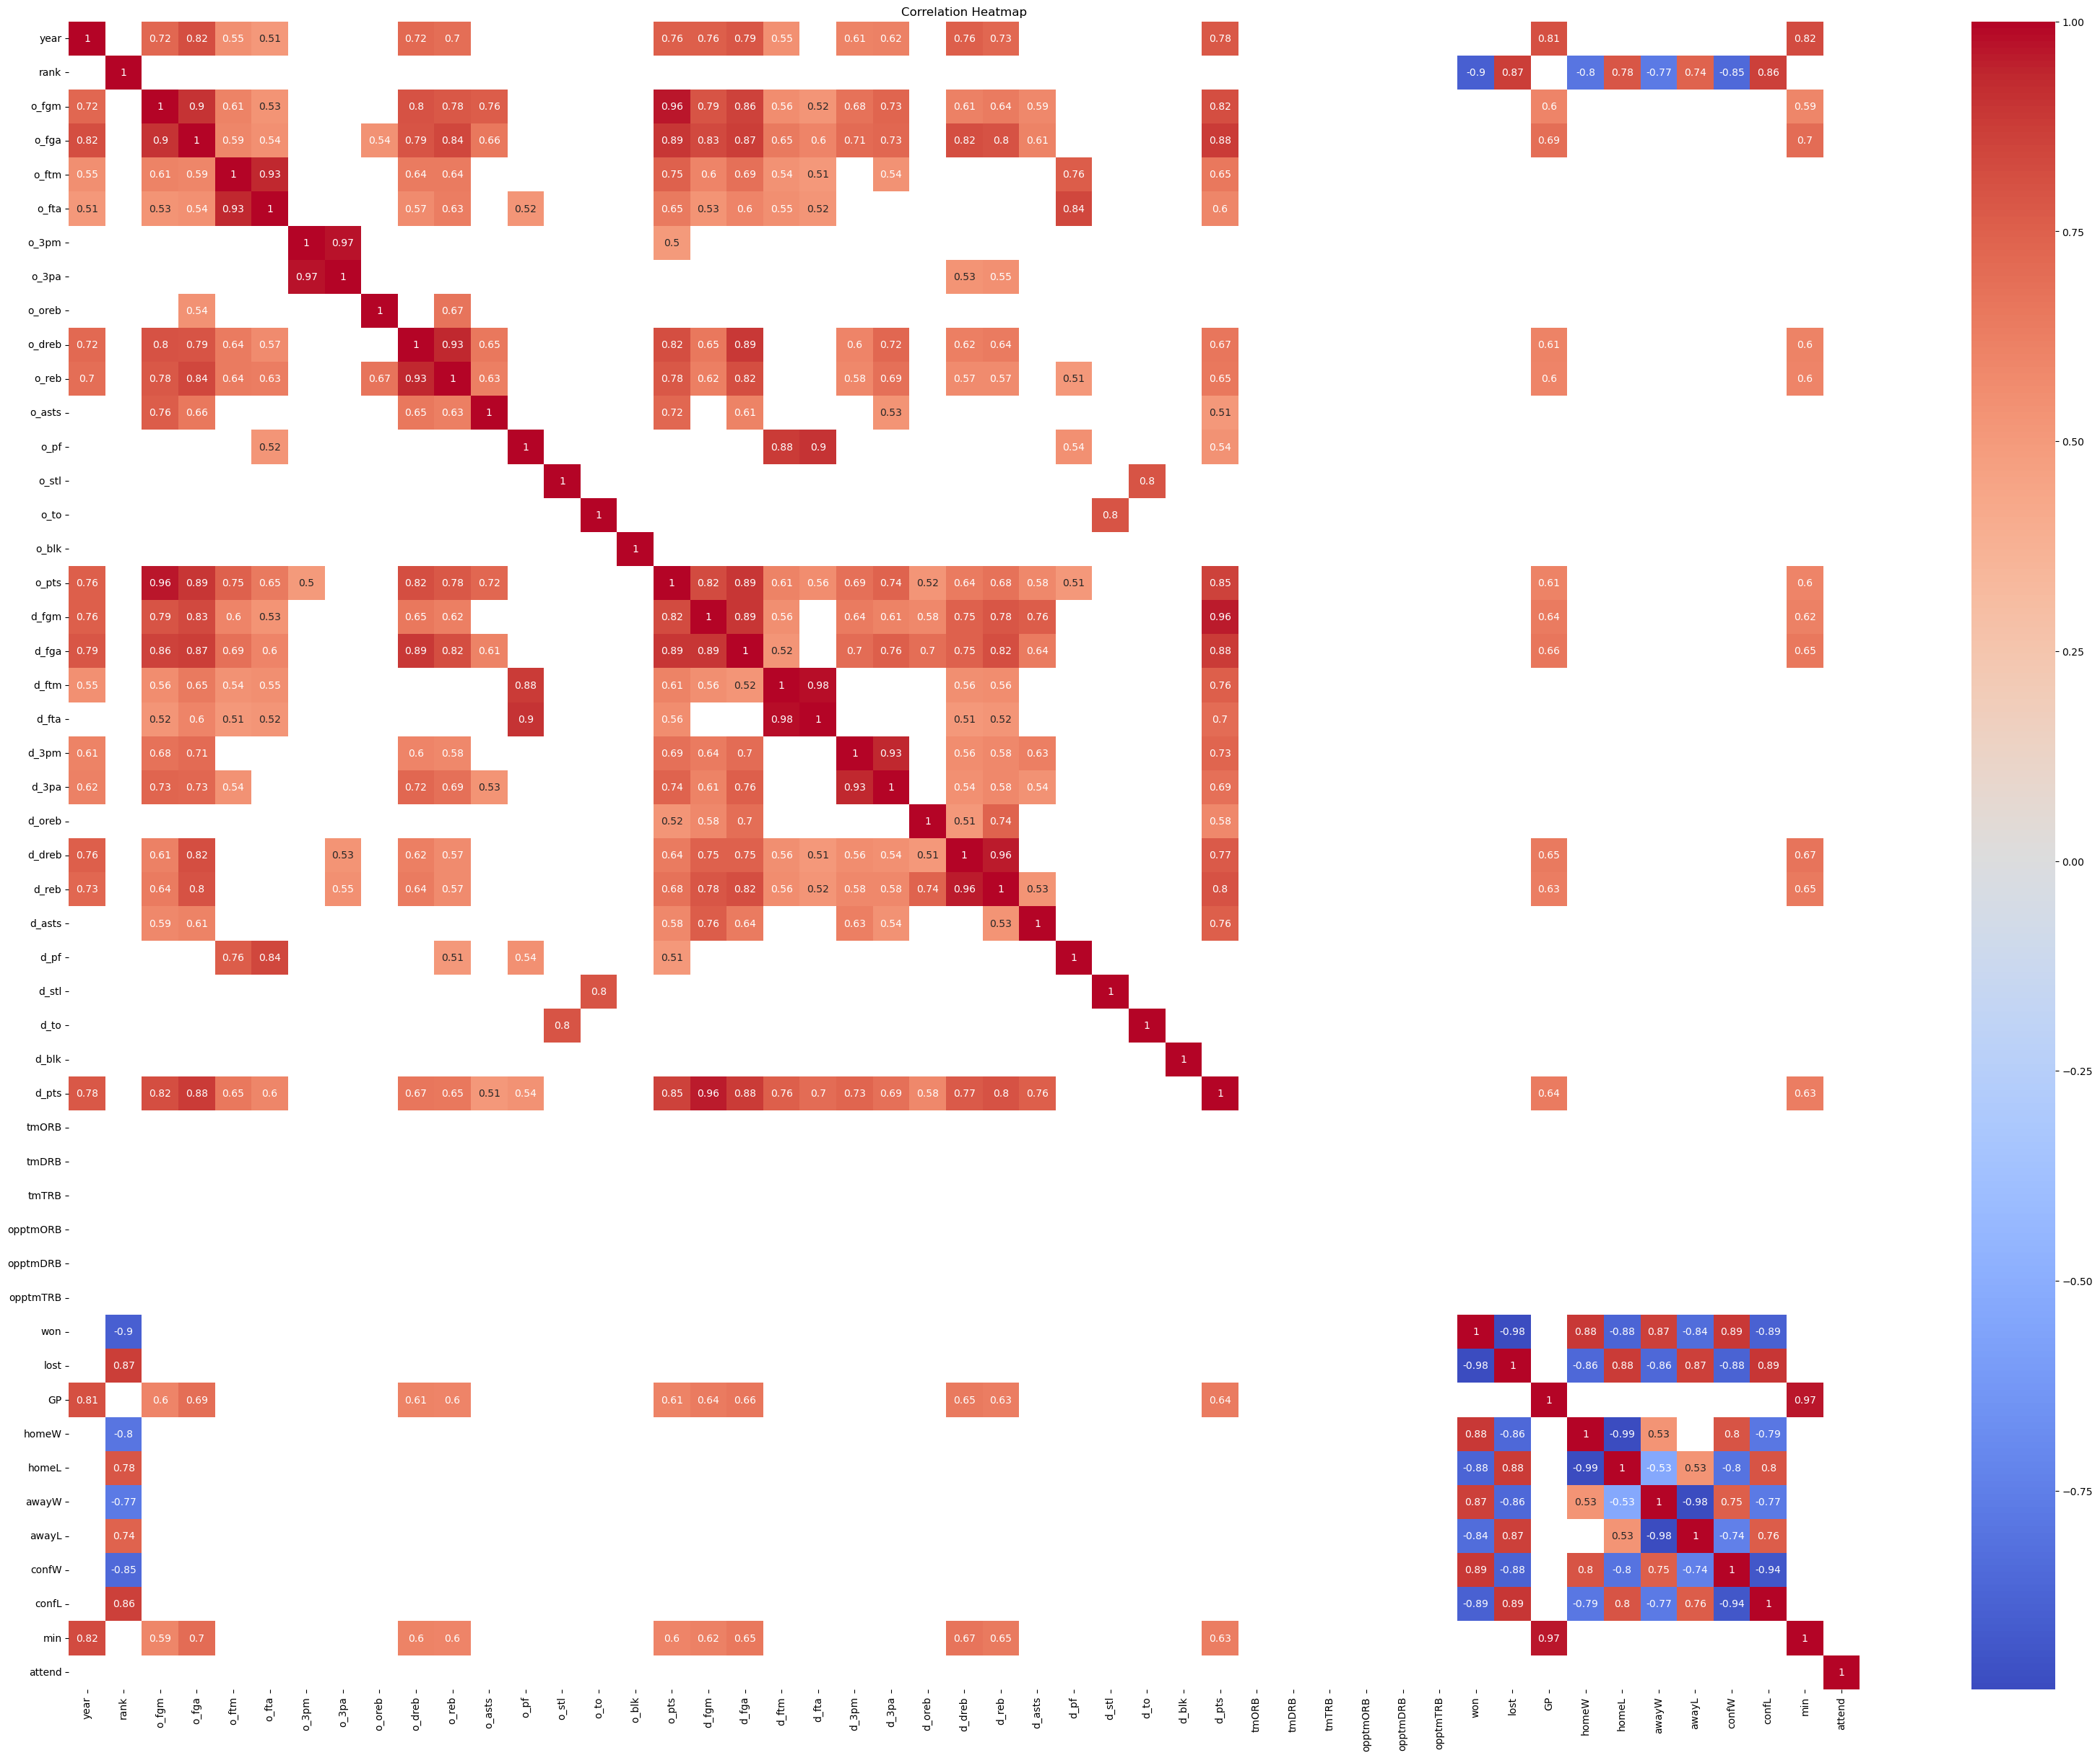

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

teams_data = pd.read_csv("Dataset/teams.csv")
teams_correlation_matrix = teams_data.corr(numeric_only=True)

# Generate a mask for the upper triangle
mask = abs(teams_correlation_matrix) < 0.5

# Create a heatmap
plt.figure(figsize=(40, 30))
sns.heatmap(teams_correlation_matrix, annot=True, cmap='coolwarm', mask=mask)

plt.title('Correlation Heatmap')
plt.show()

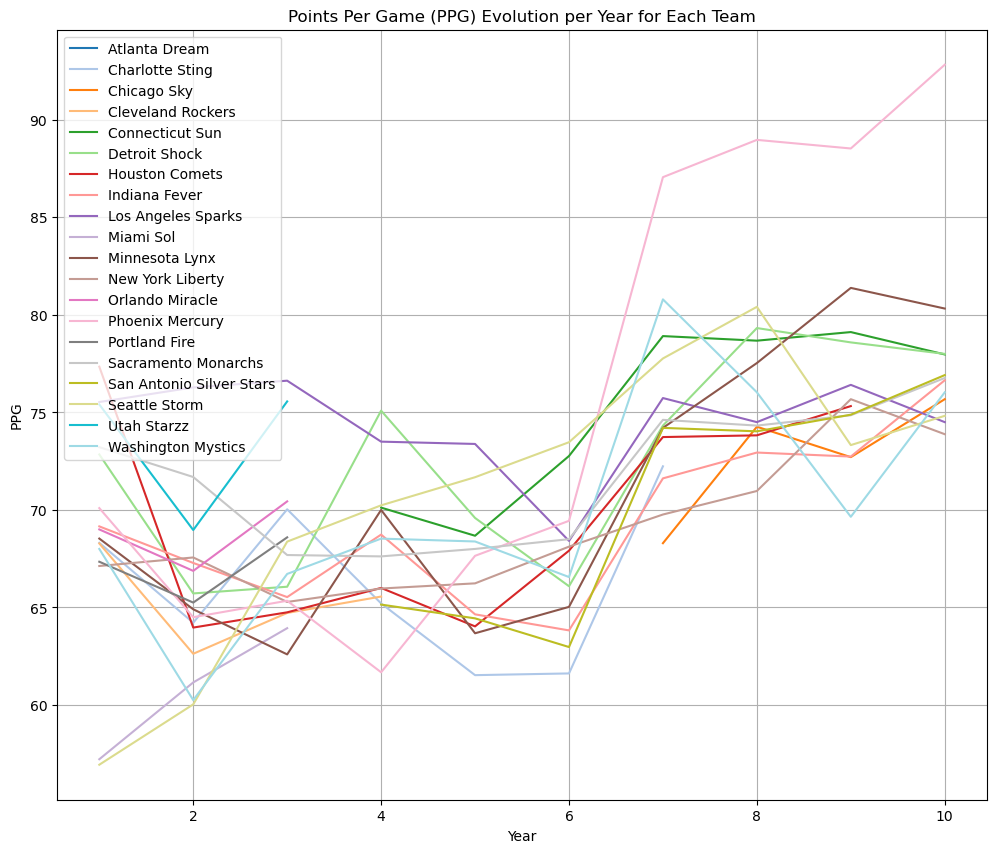

In [13]:
# Add points per game (PPG) column
teams_data['PPG'] = teams_data['o_pts'] / teams_data['GP']

ppg_per_team = teams_data.groupby(['name', 'year'])['PPG'].mean().reset_index()

plt.figure(figsize=(12, 10))

colors = plt.cm.tab20([i/len(ppg_per_team['name'].unique()) for i in range(len(ppg_per_team['name'].unique()))])
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

for team in ppg_per_team['name'].unique():
    team_data = ppg_per_team[ppg_per_team['name'] == team]
    plt.plot(team_data['year'], team_data['PPG'], label=team)

plt.title('Points Per Game (PPG) Evolution per Year for Each Team')
plt.xlabel('Year')
plt.ylabel('PPG')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [14]:
# Read players_data
players_teams_data = pd.read_csv("Dataset/players_teams.csv")
players_info_data = pd.read_csv("Dataset/players.csv")

# Merge players_teams_data and players_info_data
players_data = pd.merge(players_teams_data, players_info_data, left_on='playerID', right_on='bioID', how='left')

# Drop rows that are not needed
players_data = players_data[players_data.pos.notnull()]
players_data.drop(players_data[players_data['weight'] < 60].index, inplace = True)
players_data.drop(players_data[players_data['height'] < 50 ].index, inplace = True)
players_data.drop(columns=["firstseason","lastseason","deathDate"],inplace=True)
players_data.reset_index()
players_data.describe()

players_data.head()

,playerID,year,stint,tmID,GP,GS,minutes,points,oRebounds,dRebounds,...,PostthreeAttempted,PostthreeMade,PostDQ,bioID,pos,height,weight,college,collegeOther,birthDate
0,abrossv01w,2,0,MIN,26,23,846,343,43,131,...,0,0,0,abrossv01w,F,74.0,169,Connecticut,NaN,1980-07-09
1,abrossv01w,3,0,MIN,27,27,805,314,45,101,...,0,0,0,abrossv01w,F,74.0,169,Connecticut,NaN,1980-07-09
2,abrossv01w,4,0,MIN,30,25,792,318,44,97,...,7,3,0,abrossv01w,F,74.0,169,Connecticut,NaN,1980-07-09
3,abrossv01w,5,0,MIN,22,11,462,146,17,57,...,8,2,0,abrossv01w,F,74.0,169,Connecticut,NaN,1980-07-09
4,abrossv01w,6,0,MIN,31,31,777,304,29,78,...,0,0,0,abrossv01w,F,74.0,169,Connecticut,NaN,1980-07-09


In [15]:
# Read awards data
awards_players_data = pd.read_csv("Dataset/awards_players.csv")

# Add awards column to players_data
players_data['awards'] = 0

for idx, player in players_data.iterrows():
    awards_until_target_season = awards_players_data[(awards_players_data['playerID'] == player['playerID']) & (awards_players_data['year'] < player['year'])]
    if(not awards_until_target_season.empty):
        players_data.loc[[idx], 'awards'] =  len(awards_until_target_season)

players_data.head()

,playerID,year,stint,tmID,GP,GS,minutes,points,oRebounds,dRebounds,...,PostthreeMade,PostDQ,bioID,pos,height,weight,college,collegeOther,birthDate,awards
0,abrossv01w,2,0,MIN,26,23,846,343,43,131,...,0,0,abrossv01w,F,74.0,169,Connecticut,NaN,1980-07-09,0
1,abrossv01w,3,0,MIN,27,27,805,314,45,101,...,0,0,abrossv01w,F,74.0,169,Connecticut,NaN,1980-07-09,0
2,abrossv01w,4,0,MIN,30,25,792,318,44,97,...,3,0,abrossv01w,F,74.0,169,Connecticut,NaN,1980-07-09,0
3,abrossv01w,5,0,MIN,22,11,462,146,17,57,...,2,0,abrossv01w,F,74.0,169,Connecticut,NaN,1980-07-09,0
4,abrossv01w,6,0,MIN,31,31,777,304,29,78,...,0,0,abrossv01w,F,74.0,169,Connecticut,NaN,1980-07-09,0


In [21]:
from datetime import datetime, date

# Convert birthDate to age
def age(born, year): 
    born = datetime.strptime(born, "%Y-%m-%d").date()
    today = date.today()
    return (today.year-(25-year)) - born.year - ((today.month, today.day) < (born.month, born.day)) 

# Add variables to teams data

for idx, team in teams_data.iterrows():
        # Add average player height column to teams_data
        team_players_until_target_season = players_data[(players_data["year"] == team["year"] )&( players_data["tmID"] == team["tmID"])]
        team_players_avg_height = team_players_until_target_season["height"].mean()
        teams_data.loc[[idx], 'avg_height'] = team_players_avg_height

        # Add average player weight column to teams_data
        team_players_avg_weight = team_players_until_target_season["weight"].mean()
        teams_data.loc[[idx], 'avg_weight'] = team_players_avg_weight

        # Add average player age column to teams_data
        players_ages = team_players_until_target_season["birthDate"].apply(age, args=(team["year"],))
        team_players_avg_age = players_ages.mean()
        teams_data.loc[[idx], 'avg_age'] = team_players_avg_age

        # Add awards column to teams_data
        players = players_data[(players_data["year"] == team["year"] )&( players_data["tmID"] == team["tmID"])]
        team_awards_num = players["awards"].sum()
        teams_data.loc[[idx], 'awards'] = team_awards_num

        # Add number of playoff qualified in last two seasons; 1 if qualified only two years ago, 2 if only last season and 3 if both
        playoff_last_two = 0
        last_season = teams_data[(teams_data["year"] == team["year"]-1)&( teams_data["tmID"] == team["tmID"])]
        older_season = teams_data[(teams_data["year"] == team["year"]-2)&( teams_data["tmID"] == team["tmID"])]
        if(not last_season.empty):
            if(last_season.iloc[0]["playoff"]=='Y'):
                playoff_last_two+=2
        if(not older_season.empty):
            if(older_season.iloc[0]["playoff"]=='Y'):
                playoff_last_two+=1
        teams_data.loc[[idx], 'last_two_playoff'] = playoff_last_two

        columns_to_create = ["points","oRebounds","dRebounds","rebounds","assists","steals","blocks","turnovers","PF","fgAttempted","fgMade","ftAttempted","ftMade","threeAttempted","threeMade","dq","PostGP","PostGS","PostMinutes","PostPoints","PostoRebounds","PostdRebounds","PostRebounds","PostAssists","PostSteals","PostBlocks","PostTurnovers","PostPF","PostfgAttempted","PostfgMade","PostftAttempted","PostftMade","PostthreeAttempted","PostthreeMade","PostDQ"]
        # Add mean of values for players in actual team on previus two years
        for column in columns_to_create:
            teams_data.loc[[idx], column] = 0
        for idx2, player in players.iterrows():
            player_last_season = players_data[(players_data["year"] == player["year"]-1)&( players_data["playerID"] == player["playerID"])]
            player_older_season = players_data[(players_data["year"] == player["year"]-2)&( players_data["playerID"] == player["playerID"])]
            if(not player_last_season.empty):
                if(not player_older_season.empty):
                    for column in columns_to_create:
                        teams_data.loc[[idx], column] +=  player_last_season.iloc[0][column]*.5+ player_older_season.iloc[0][column]*.5
                else:  
                    for column in columns_to_create:    
                        teams_data.loc[[idx], column] +=  player_last_season.iloc[0][column]



columns_to_replace = ["o_fgm","o_fga","o_ftm","o_fta","o_3pm","o_3pa","o_oreb","o_dreb","o_reb","o_asts",
                      "o_pf","o_stl","o_to","o_blk","o_pts","d_fgm","d_fga","d_ftm","d_fta","d_3pm",
                      "d_3pa","d_oreb","d_dreb","d_reb","d_asts","d_pf","d_stl","d_to","d_blk","d_pts",
                      "tmORB","tmDRB","tmTRB","opptmORB","opptmDRB","opptmTRB","won","lost","GP",
                      "homeW","homeL","awayW","awayL","confW","confL","min","attend","PPG"]

teams_data_2=teams_data.copy()
for idx, team in teams_data_2.iterrows():
        last_season = teams_data[(teams_data["year"] == team["year"]-1)&( teams_data["tmID"] == team["tmID"])]
        older_season = teams_data[(teams_data["year"] == team["year"]-2)&( teams_data["tmID"] == team["tmID"])]
        if(not last_season.empty):
            if(not older_season.empty):
                for column in columns_to_replace:
                    teams_data_2.loc[[idx], column] = last_season.iloc[0][column]/2+older_season.iloc[0][column]/2      
            else:     
                for column in columns_to_replace:   
                    teams_data_2.loc[[idx], column] = last_season.iloc[0][column] 
            
teams_data


,year,tmID,confID,rank,playoff,firstRound,semis,finals,name,o_fgm,...,PostBlocks,PostTurnovers,PostPF,PostfgAttempted,PostfgMade,PostftAttempted,PostftMade,PostthreeAttempted,PostthreeMade,PostDQ
0,1,CHA,EA,8,N,NaN,NaN,NaN,Charlotte Sting,812,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,CHA,EA,4,Y,W,W,L,Charlotte Sting,746,...,2.0,12.0,26.0,47.0,15.0,16.0,10.0,26.0,6.0,0.0
2,3,CHA,EA,2,Y,L,NaN,NaN,Charlotte Sting,770,...,20.0,58.5,88.5,242.0,98.0,55.0,41.0,64.5,22.5,0.0
3,4,CHA,EA,2,Y,L,NaN,NaN,Charlotte Sting,787,...,16.5,54.0,76.5,245.0,97.5,52.0,38.5,68.5,23.5,0.0
4,5,CHA,EA,5,N,NaN,NaN,NaN,Charlotte Sting,745,...,4.5,16.0,23.5,92.0,34.5,20.0,13.5,32.0,10.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,10,PHO,WE,1,Y,W,W,W,Phoenix Mercury,1128,...,13.0,32.5,50.5,237.5,110.0,60.5,50.5,100.5,40.0,0.5
137,10,SAC,WE,6,N,NaN,NaN,NaN,Sacramento Monarchs,946,...,8.0,42.5,59.5,160.0,80.0,49.5,40.0,32.0,11.5,0.5
138,10,SAS,WE,4,Y,L,NaN,NaN,San Antonio Silver Stars,936,...,27.5,93.5,104.5,439.0,188.5,124.0,102.5,107.0,42.0,0.5
139,10,SEA,WE,2,Y,L,NaN,NaN,Seattle Storm,909,...,11.5,41.5,51.5,177.5,75.0,46.5,34.0,43.0,13.5,0.0


In [24]:
teams_data[["year","tmID","points"]]


,year,tmID,points
0,1,CHA,0.0
1,2,CHA,1959.0
2,3,CHA,2043.5
3,4,CHA,2077.0
4,5,CHA,1846.0
...,...,...,...
136,10,PHO,2553.0
137,10,SAC,2514.5
138,10,SAS,2203.5
139,10,SEA,2116.0


## Algorithms

### Data split

In [69]:
teams_data.drop(columns=['rank', 'firstRound', 'semis', 'finals'],inplace=True)

char_map = {'N': 0, 'Y': 1, 'L': 0, 'W': 1}
teams_data['playoff'] = teams_data['playoff'].map(char_map)
teams_data['playoff'] = teams_data['playoff'].fillna(-1)

tmIds = teams_data['tmID'].unique()
for i in range (len(tmIds)):
    teams_data['tmID'] = teams_data['tmID'].replace(tmIds[i],i)

confids = teams_data['confID'].unique()
for i in range (len(confids)):
    teams_data['confID'] = teams_data['confID'].replace(confids[i],i)

arenas = teams_data['arena'].unique()
for i in range (len(arenas)):
    teams_data['arena'] = teams_data['arena'].replace(arenas[i],i)

tmNames = teams_data['name'].unique()
for i in range (len(tmNames)):
    teams_data['name'] = teams_data['name'].replace(tmNames[i],i)

teams_test = teams_data[teams_data['year'] == 9]
teams_data = teams_data[teams_data['year'] < 9]


X_train, X_test, y_train, y_test = teams_data.drop(columns=['playoff']), teams_test.drop(columns=['playoff']), teams_data['playoff'], teams_test['playoff']

### Abstract Model

In [70]:
from abc import ABC, abstractmethod
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score

class AbstractModel(ABC):
    def __init__(self, X_train, X_test, y_train, y_test, algorithm):
        self.X_train = X_train.values
        self.X_test = X_test.values
        self.y_train = y_train.values
        self.y_test = y_test.values
        self.algorithm = algorithm

    @abstractmethod
    def train(self):
        pass

    def predict(self, clf):
        return clf.predict(self.X_test)

    def evaluate(self, pred):
        return {
            'accuracy': accuracy_score(self.y_test, pred),
            'f1_score': f1_score(self.y_test, pred)
        }

    def confusion_matrix(self, pred):
        cm = confusion_matrix(self.y_test, pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
        disp.plot()

### Decision Tree

In [71]:
from sklearn import tree

class DecisionTreeModel(AbstractModel):
    def __init__(self, X_train, X_test, y_train, y_test):
        super().__init__(X_train, X_test, y_train, y_test, tree.DecisionTreeClassifier())

    def train(self):
        clf = self.algorithm.fit(self.X_train, self.y_train)
        return clf

### Support Vector Machine

In [72]:
from sklearn import svm

class SVMModel(AbstractModel):
    def __init__(self, X_train, X_test, y_train, y_test):
        super().__init__(X_train, X_test, y_train, y_test, svm.SVC())

    def train(self):
        clf = self.algorithm.fit(self.X_train, self.y_train)
        return clf

### Naive Bayes

In [73]:
from sklearn.naive_bayes import GaussianNB

class NaiveBayesModel(AbstractModel):
    def __init__(self, X_train, X_test, y_train, y_test):
        super().__init__(X_train, X_test, y_train, y_test, GaussianNB())

    def train(self):
        clf = self.algorithm.fit(self.X_train, self.y_train)
        return clf

### Neural Network

In [74]:
from sklearn.neural_network import MLPClassifier

class NeuralNetworkModel(AbstractModel):
    def __init__(self, X_train, X_test, y_train, y_test):
        super().__init__(X_train, X_test, y_train, y_test, MLPClassifier())

    def train(self):
        clf = self.algorithm.fit(self.X_train, self.y_train)
        return clf

### Apply models

{'accuracy': 0.8461538461538461, 'f1_score': 0.8571428571428571}


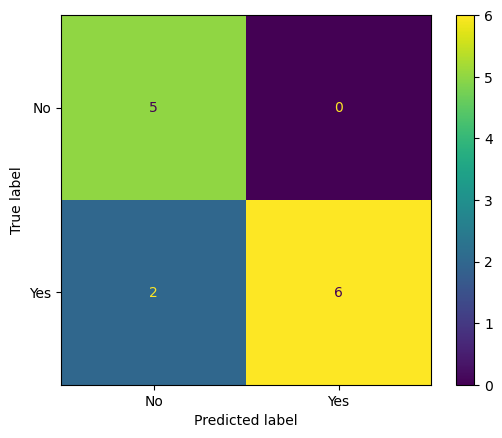

In [75]:
# Apply Decision Tree Model
decisionTreeModel = DecisionTreeModel(X_train, X_test, y_train, y_test)
clf = decisionTreeModel.train()
pred = decisionTreeModel.predict(clf)
print(decisionTreeModel.evaluate(pred))
decisionTreeModel.confusion_matrix(pred)

{'accuracy': 0.6153846153846154, 'f1_score': 0.761904761904762}


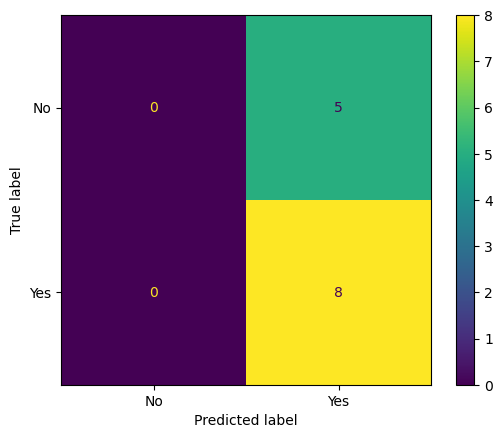

In [76]:
# Apply SVM Model
svmModel = SVMModel(X_train, X_test, y_train, y_test)
clf = svmModel.train()
pred = svmModel.predict(clf)
print(svmModel.evaluate(pred))
svmModel.confusion_matrix(pred)

{'accuracy': 0.6923076923076923, 'f1_score': 0.7777777777777777}


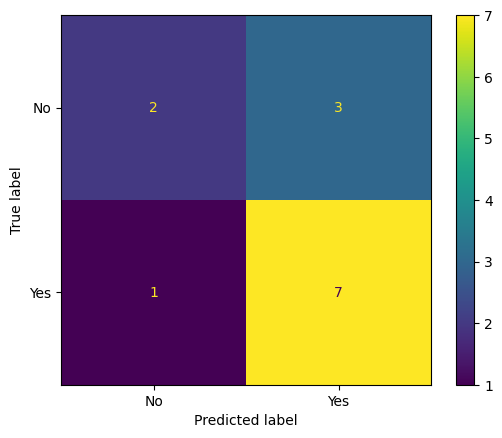

In [77]:
# Apply Naive Bayes Model
naiveBayesModel = NaiveBayesModel(X_train, X_test, y_train, y_test)
clf = naiveBayesModel.train()
pred = naiveBayesModel.predict(clf)
print(naiveBayesModel.evaluate(pred))
naiveBayesModel.confusion_matrix(pred)

{'accuracy': 0.3076923076923077, 'f1_score': 0.0}


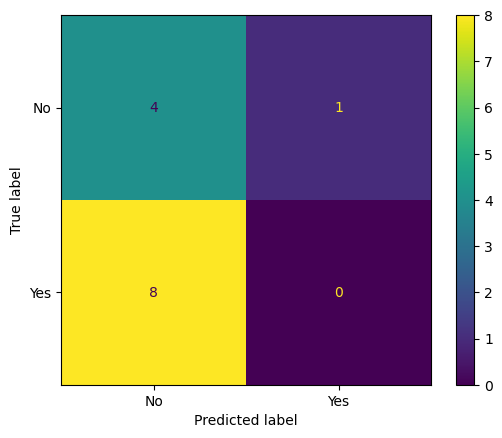

In [78]:
# Apply Neural Network Model
neuralNetworkModel = NeuralNetworkModel(X_train, X_test, y_train, y_test)
clf = neuralNetworkModel.train()
pred = neuralNetworkModel.predict(clf)
print(neuralNetworkModel.evaluate(pred))
neuralNetworkModel.confusion_matrix(pred)